In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression, ElasticNet, Lasso, Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import  LabelEncoder
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error
import xgboost as xgb
import re
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA

# 데이터 불러오기

In [2]:
df = pd.read_csv('../data/apt161718.csv', low_memory=False, dtype={'status': 'category'})

# 데이터 EDA 및 전처리 1

# 분석에 맞는 데이터 필터링 & 컬럼 정리

In [3]:
df.head()
# 문자, 숫자 섞여 있는 데이터

,시군구,번지,본번,부번,단지명,전월세구분,전용면적(㎡),계약년월,계약일,보증금(만원),...,층,건축년도,도로명,계약기간,계약구분,갱신요구권 사용,종전계약 보증금 (만원),종전계약 월세 (만원),금리,부동산소비심리
0,서울특별시 강남구 개포동,658-1,658.0,1.0,개포6차우성아파트1동~8동,전세,79.97,201601,7,"44,000",...,2,1987,언주로 3,-,-,-,NaN,NaN,1.5,117.6
1,서울특별시 강남구 개포동,658-1,658.0,1.0,개포6차우성아파트1동~8동,월세,79.97,201601,16,"5,000",...,1,1987,언주로 3,-,-,-,NaN,NaN,1.5,117.6
2,서울특별시 강남구 개포동,658-1,658.0,1.0,개포6차우성아파트1동~8동,전세,79.97,201601,21,"42,000",...,1,1987,언주로 3,-,-,-,NaN,NaN,1.5,117.6
3,서울특별시 강남구 개포동,652,652.0,0.0,개포우성3차,전세,133.46,201601,12,"80,000",...,6,1984,개포로 307,-,-,-,NaN,NaN,1.5,117.6
4,서울특별시 강남구 개포동,652,652.0,0.0,개포우성3차,전세,104.43,201601,15,"52,000",...,4,1984,개포로 307,-,-,-,NaN,NaN,1.5,117.6


In [4]:
df.shape
# 4,822,002 개의 레코드 데이터, 21개 컬럼

(482002, 21)

In [5]:
# 컬럼 : 시군구, 번지, 본번, 부번, 단지명, 전월세구분, 전용면적(㎡), 계약년월, 계약일, 보증금(만원), 월세(만원), 층, 건축년도, 도로명, 계약기간, 계약구분,
#         갱신요구권 사용, 종전계약 보증금 (만원), 종전계약 월세 (만원), 금리, 부동산소비심리


# 컬럼 중 시군구, 번지, 본번, 부번, 도로명은 서로 성격이 겹치는 컬럼이기에 하나로 대표할 수 있는 시군구 컬럼만 남김
# 컬럼 중 계약년월, 계약일 중 계약일 컬럼만 남김
# 알아내고자 하는 것이 보증금이기 때문에 계약기간(유효한 값이 거의 없기에 그냥 삭제하기로함), 계약구분, 개신요구권사용, 종전계약보증금(만원), 종전계약 월세(만원)은 삭제하여 활용하기로 함 
# 이중에서도 전세에 관한 것을 알기 위해 전월세구분에서 전세로 필터링해 활용함


# 단어 의미 확인하기
# 시군구 : 행정 구역인 시와 군, 구를 아울러 이르는 말
# 단지명 : 주택, 공장, 작물 재배지 따위가 집단을 이루고 있는 일정 구역의 이름
# 전세 : 부동산의 소유주에게 일정한 돈을 맡기고 집이나 방을 빌려 쓰다가, 내놓을 때 그 돈의 전액을 돌려받는 제도 
# 전용면적 : 아파트 따위의 공동 주택에서, 출입구나 엘리베이터, 계단 등의 공유 면적을 제외한 바닥 넓이
# 계약년월 : 계약을 진행한 연도와 월
# 보증금 : 입찰 또는 계약을 맺을 때 계약 이행의 담보로 내는 금전
# 층 : 건물의 층 
# 건축년도 : 건물 완공 년
# 금리 : 금융 기관에서 빌려준 돈이나 예금 따위에 대한 이율
# 부동산소비심리 : 부동산에서 반응하는 소비자들의 심리 수준, 형태 변화 및 인지 수준을 파악한 뒤 지수화한 값

In [6]:
#우리가 알고자 하는 주제는 전세이기 때문에 필터링 진행
df = df[df['전월세구분'] == '전세']


# 서울시 동별 보증금이 다를 것이라는 가설을 전제로 '동' 컬럼 추가
df['동'] = df['시군구'].str.replace('서울특별시', '')
df = df[df['전월세구분'] == '전세']
remove_gu = ['서울특별시 ', '강남구 ', '강동구 ', '강북구 ', '강서구 ', '관악구 ', '광진구 ','구로구 ', '금천구 ', '노원구 ', '도봉구 ', '동대문구 ', '동작구 ', '마포구 ', '서대문구 ', '서초구 ', '성동구 ', '성북구 ','송파구 ' , '양천구 ', '영등포구 ', '용산구 ', '은평구 ', '종로구 ', '중구 ', '중랑구 ']
df['동'] = df['시군구'].str.replace('|'.join(remove_gu), '', regex=True)


#데이터 보기 편하게 재배열
df = df[['시군구', '동', '단지명','전월세구분','전용면적(㎡)','계약년월','층', '건축년도', '금리','부동산소비심리', '보증금(만원)']]


# 보증금(만원) 컬럼이 문자로 저장되어 있어 숫자로 변환
df['보증금(만원)'] = df['보증금(만원)'].str.replace(",", "").astype(int)


# 전용면적(㎡), 보증금(만원) 컬럼명에서 ()가 들어가 삭제함
df.rename(columns={'전용면적(㎡)': '전용면적'}, inplace=True)
df.rename(columns={'보증금(만원)': '보증금'}, inplace=True)

df.head()


,시군구,동,단지명,전월세구분,전용면적,계약년월,층,건축년도,금리,부동산소비심리,보증금
0,서울특별시 강남구 개포동,개포동,개포6차우성아파트1동~8동,전세,79.97,201601,2,1987,1.5,117.6,44000
2,서울특별시 강남구 개포동,개포동,개포6차우성아파트1동~8동,전세,79.97,201601,1,1987,1.5,117.6,42000
3,서울특별시 강남구 개포동,개포동,개포우성3차,전세,133.46,201601,6,1984,1.5,117.6,80000
4,서울특별시 강남구 개포동,개포동,개포우성3차,전세,104.43,201601,4,1984,1.5,117.6,52000
5,서울특별시 강남구 개포동,개포동,개포우성3차,전세,104.43,201601,1,1984,1.5,117.6,55000


# 각 컬럼에 대한 특징 파악하기

In [7]:
# 1) 피처(Feature) 확인
df.columns

Index(['시군구', '동', '단지명', '전월세구분', '전용면적', '계약년월', '층', '건축년도', '금리',
       '부동산소비심리', '보증금'],
      dtype='object')

In [8]:
# 2) 데이터 프레임 정보 확인
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 328695 entries, 0 to 482001
Data columns (total 11 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   시군구      328695 non-null  object 
 1   동        328695 non-null  object 
 2   단지명      328695 non-null  object 
 3   전월세구분    328695 non-null  object 
 4   전용면적     328695 non-null  float64
 5   계약년월     328695 non-null  int64  
 6   층        328695 non-null  int64  
 7   건축년도     328695 non-null  int64  
 8   금리       328695 non-null  float64
 9   부동산소비심리  328695 non-null  float64
 10  보증금      328695 non-null  int32  
dtypes: float64(3), int32(1), int64(3), object(4)
memory usage: 28.8+ MB


In [9]:
# 3) 데이터 프레임 통계값 (전체)
df.describe()

,전용면적,계약년월,층,건축년도,금리,부동산소비심리,보증금
count,328695.000000,328695.000000,328695.000000,328695.000000,328695.000000,328695.000000,328695.000000
mean,77.441354,201712.013170,8.812784,1998.911894,1.389266,118.376674,41178.943623
std,27.911234,82.077535,5.965429,10.767297,0.140425,9.000347,23630.392391
min,10.110000,201601.000000,-2.000000,1961.000000,1.250000,93.900000,500.000000
25%,59.730000,201610.000000,4.000000,1990.000000,1.250000,113.100000,26000.000000
50%,82.610000,201707.000000,8.000000,2000.000000,1.500000,119.200000,37000.000000
75%,84.970000,201804.000000,12.000000,2007.000000,1.500000,126.300000,50000.000000
max,317.360000,201812.000000,68.000000,2022.000000,1.750000,134.100000,500000.000000


In [10]:
# 동 : 서울의 동을 나누었을 때 332개로 나누었으며(충무로1가, 장충동2가 등 포함) 가장 많은 거래(12,727건)가 상계동에서 있었다는 것을 알 수 있음
df.동.describe()

count     328695
unique       332
top          상계동
freq       12727
Name: 동, dtype: object

In [11]:
# 단지명 : 6735의 서로 다른 아파트들이 있다는 것을 알 수 있음 -> 아파트명이 많이 겹침
df.단지명.describe()

count     328695
unique      6735
top           현대
freq        2735
Name: 단지명, dtype: object

In [12]:
# 전용면적 : 거래된 아파트 중 가장 작은 전용면적은 10.11(㎡), 가장 넓은 전용면적은 317.36(㎡) 임
df.전용면적.describe()

count    328695.000000
mean         77.441354
std          27.911234
min          10.110000
25%          59.730000
50%          82.610000
75%          84.970000
max         317.360000
Name: 전용면적, dtype: float64

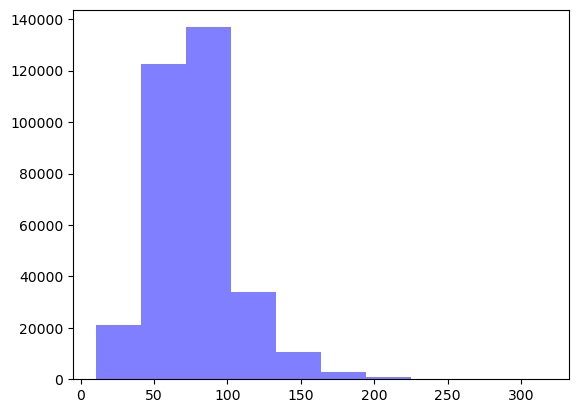

In [13]:
plt.hist(df['전용면적'], bins=10, facecolor='blue', alpha=0.5)
plt.show()
#대부분 50~100사이의 면적거래가 있었다는 것을 알 수 있음

In [14]:
# 계약년월 : 201601~201812 까지의 자료임을 알 수 있음
df.계약년월.describe()

count    328695.000000
mean     201712.013170
std          82.077535
min      201601.000000
25%      201610.000000
50%      201707.000000
75%      201804.000000
max      201812.000000
Name: 계약년월, dtype: float64

In [15]:
# 층 : -2~68층까지 분포 (지하층이 있는지 확인)
df.층.describe()

count    328695.000000
mean          8.812784
std           5.965429
min          -2.000000
25%           4.000000
50%           8.000000
75%          12.000000
max          68.000000
Name: 층, dtype: float64

In [16]:
#지하층 있는 곳 파악 , -1층, 19곳
df.loc[df['층']==-1]

,시군구,동,단지명,전월세구분,전용면적,계약년월,층,건축년도,금리,부동산소비심리,보증금
3055,서울특별시 관악구 남현동,남현동,관악산센텀,전세,19.2600,201601,-1,2013,1.50,117.6,6000
17025,서울특별시 구로구 천왕동,천왕동,천왕연지타운1단지,전세,84.8700,201602,-1,2013,1.50,120.1,27500
55843,서울특별시 구로구 천왕동,천왕동,천왕연지타운2단지,전세,84.9900,201605,-1,2014,1.50,126.4,41000
66190,서울특별시 관악구 남현동,남현동,관악산센텀,전세,23.6200,201606,-1,2013,1.25,126.6,8000
78219,서울특별시 관악구 남현동,남현동,관악산센텀,전세,26.6700,201607,-1,2013,1.25,128.8,5000
86899,서울특별시 중구 신당동,신당동,글로리안(A),전세,59.9000,201607,-1,2002,1.25,128.8,14000
112158,서울특별시 용산구 동자동,동자동,동자,전세,42.2300,201609,-1,1969,1.25,127.4,10000
127543,서울특별시 용산구 이촌동,이촌동,강변,전세,66.0800,201610,-1,1971,1.25,128.7,13000
211613,서울특별시 중구 신당동,신당동,하영,전세,59.6200,201704,-1,2002,1.25,119.2,14000
223385,서울특별시 용산구 이촌동,이촌동,강변,전세,66.0800,201705,-1,1971,1.25,126.2,9000


In [17]:
#지하층 있는 곳 파악 , -2층, 6곳
df.loc[df['층']==-2]

,시군구,동,단지명,전월세구분,전용면적,계약년월,층,건축년도,금리,부동산소비심리,보증금
140712,서울특별시 은평구 불광동,불광동,불광롯데캐슬,전세,95.49,201611,-2,2013,1.25,113.8,57000
155773,서울특별시 은평구 진관동,진관동,우물골2단지두산위브(223~244동)BL2-7,전세,134.48,201612,-2,2010,1.25,102.8,45000
304072,서울특별시 구로구 천왕동,천왕동,천왕연지타운1단지,전세,84.95,201712,-2,2013,1.50,114.8,40000
417883,서울특별시 성동구 옥수동,옥수동,옥수파크힐스101동~116동,전세,107.99,201808,-2,2016,1.50,127.5,104000
426587,서울특별시 구로구 천왕동,천왕동,천왕연지타운2단지,전세,84.87,201809,-2,2014,1.50,126.2,43000
476660,서울특별시 성동구 옥수동,옥수동,옥수파크힐스101동~116동,전세,76.66,201812,-2,2016,1.75,93.9,75000


In [18]:
# 건축년도 : 1961년도~2022년도 신축까지 다양함
# 왜 16~18 전세 자료인데 건축년도가 22년이 나오는가?
# 장기계속공사의 경우 건설공사계약통계는 당해 연도 계약액을 기준으로 하고 있으며, 통계청 조사는 총 공사액을 기준으로 하고 있기 때문
df.건축년도.describe()

count    328695.000000
mean       1998.911894
std          10.767297
min        1961.000000
25%        1990.000000
50%        2000.000000
75%        2007.000000
max        2022.000000
Name: 건축년도, dtype: float64

In [19]:
# 19년, 20년, 22년 건축년도와 계약년도를 맞춤
# 16~18 년도 계약이지만 건축년도가 미래에 있음. 그러나 전세 보증금의 기준은 계약년도였기 때문에 건축년도를 맞추어 데이터의 모순성 제거
search = df[(df['건축년도'] == 2019) & (df['계약년월'] == 201707)]
print(search)

                  시군구    동         단지명 전월세구분   전용면적    계약년월  층  건축년도    금리  \
239188  서울특별시 강북구 미아동  미아동  꿈의숲해링턴플레이스    전세  59.36  201707  8  2019  1.25   

        부동산소비심리    보증금  
239188    134.1  60000  


In [20]:
# 건축년도 2019년, 계약년월 201707 에 1건
# 건축년도 2019년, 계약년월 201712 에 1건
# 건축년도 2019년, 계약년월 201801 에 89건
# 건축년도 2019년, 계약년월 201802 에 71건
# 건축년도 2019년, 계약년월 201803 에 141건
# 건축년도 2019년, 계약년월 201804 에 118건
# 건축년도 2019년, 계약년월 201805 에 97건
# 건축년도 2019년, 계약년월 201806 에 120건
# 건축년도 2019년, 계약년월 201807 에 135건
# 건축년도 2019년, 계약년월 201808 에 118건
# 건축년도 2019년, 계약년월 201809 에 116건
# 건축년도 2019년, 계약년월 201810 에 129건
# 건축년도 2019년, 계약년월 201811 에 150건
# 건축년도 2019년, 계약년월 201812 에 278건
# ...

In [21]:
df.loc[(df['계약년월'].isin([201601, 201602, 201603, 201604, 201605, 201606, 201607, 201608, 201609, 201610, 201611, 201612])) & (df['건축년도'] == 2019), '건축년도'] = 2016
df.loc[(df['계약년월'].isin([201601, 201602, 201603, 201604, 201605, 201606, 201607, 201608, 201609, 201610, 201611, 201612])) & (df['건축년도'] == 2020), '건축년도'] = 2016
df.loc[(df['계약년월'].isin([201601, 201602, 201603, 201604, 201605, 201606, 201607, 201608, 201609, 201610, 201611, 201612])) & (df['건축년도'] == 2021), '건축년도'] = 2016
df.loc[(df['계약년월'].isin([201601, 201602, 201603, 201604, 201605, 201606, 201607, 201608, 201609, 201610, 201611, 201612])) & (df['건축년도'] == 2022), '건축년도'] = 2016

df.loc[(df['계약년월'].isin([201701, 201702, 201703, 201704, 201705, 201706, 201707, 201708, 201709, 201710, 201711, 201712])) & (df['건축년도'] == 2019), '건축년도'] = 2017
df.loc[(df['계약년월'].isin([201701, 201702, 201703, 201704, 201705, 201706, 201707, 201708, 201709, 201710, 201711, 201712])) & (df['건축년도'] == 2020), '건축년도'] = 2017
df.loc[(df['계약년월'].isin([201701, 201702, 201703, 201704, 201705, 201706, 201707, 201708, 201709, 201710, 201711, 201712])) & (df['건축년도'] == 2021), '건축년도'] = 2017
df.loc[(df['계약년월'].isin([201701, 201702, 201703, 201704, 201705, 201706, 201707, 201708, 201709, 201710, 201711, 201712])) & (df['건축년도'] == 2022), '건축년도'] = 2017

df.loc[(df['계약년월'].isin([201801, 201802, 201803, 201804, 201805, 201806, 201807, 201808, 201809, 201810, 201811, 201812])) & (df['건축년도'] == 2019), '건축년도'] = 2018
df.loc[(df['계약년월'].isin([201801, 201802, 201803, 201804, 201805, 201806, 201807, 201808, 201809, 201810, 201811, 201812])) & (df['건축년도'] == 2020), '건축년도'] = 2018
df.loc[(df['계약년월'].isin([201801, 201802, 201803, 201804, 201805, 201806, 201807, 201808, 201809, 201810, 201811, 201812])) & (df['건축년도'] == 2021), '건축년도'] = 2018
df.loc[(df['계약년월'].isin([201801, 201802, 201803, 201804, 201805, 201806, 201807, 201808, 201809, 201810, 201811, 201812])) & (df['건축년도'] == 2022), '건축년도'] = 2018

In [22]:
# 확인
search2 = df[(df['건축년도'] == 2019) & (df['계약년월'] == 201707)]
print(search2)

Empty DataFrame
Columns: [시군구, 동, 단지명, 전월세구분, 전용면적, 계약년월, 층, 건축년도, 금리, 부동산소비심리, 보증금]
Index: []


In [23]:
df

,시군구,동,단지명,전월세구분,전용면적,계약년월,층,건축년도,금리,부동산소비심리,보증금
0,서울특별시 강남구 개포동,개포동,개포6차우성아파트1동~8동,전세,79.97,201601,2,1987,1.50,117.6,44000
2,서울특별시 강남구 개포동,개포동,개포6차우성아파트1동~8동,전세,79.97,201601,1,1987,1.50,117.6,42000
3,서울특별시 강남구 개포동,개포동,개포우성3차,전세,133.46,201601,6,1984,1.50,117.6,80000
4,서울특별시 강남구 개포동,개포동,개포우성3차,전세,104.43,201601,4,1984,1.50,117.6,52000
5,서울특별시 강남구 개포동,개포동,개포우성3차,전세,104.43,201601,1,1984,1.50,117.6,55000
...,...,...,...,...,...,...,...,...,...,...,...
481997,서울특별시 중랑구 중화동,중화동,한신아파트(103~109),전세,59.76,201812,13,1997,1.75,93.9,28500
481998,서울특별시 중랑구 중화동,중화동,한신아파트(103~109),전세,84.03,201812,4,1997,1.75,93.9,34000
481999,서울특별시 중랑구 중화동,중화동,한신아파트(103~109),전세,50.37,201812,20,1997,1.75,93.9,27000
482000,서울특별시 중랑구 중화동,중화동,한신아파트(103~109),전세,59.76,201812,13,1997,1.75,93.9,29000


In [24]:
# 보증금 : 제일 저렴한 것은 500만원, 비싼 것은 500000만원(50억.. ㅎ)이 나온다는 것을 알 수 있음 
df.보증금.describe()

count    328695.000000
mean      41178.943623
std       23630.392391
min         500.000000
25%       26000.000000
50%       37000.000000
75%       50000.000000
max      500000.000000
Name: 보증금, dtype: float64

In [25]:
#저렴한 곳
df.loc[df['보증금']==500]

,시군구,동,단지명,전월세구분,전용면적,계약년월,층,건축년도,금리,부동산소비심리,보증금
116727,서울특별시 강서구 화곡동,화곡동,아델리아Ⅰ,전세,10.92,201610,4,2012,1.25,128.7,500
330417,서울특별시 강서구 가양동,가양동,가양2단지(성지),전세,49.56,201802,14,1992,1.50,126.3,500
349063,서울특별시 도봉구 방학동,방학동,방학지음재힐스,전세,14.79,201803,3,2018,1.50,116.3,500
362478,서울특별시 구로구 오류동,오류동,오류동역솔리스타,전세,19.27,201804,7,2016,1.50,108.3,500
376005,서울특별시 도봉구 방학동,방학동,방학지음재힐스,전세,14.86,201805,3,2018,1.50,109.8,500
452175,서울특별시 종로구 창신동,창신동,동대문,전세,28.80,201810,5,1966,1.50,115.1,500


In [26]:
#비싼곳
df.loc[df['보증금']==500000]

,시군구,동,단지명,전월세구분,전용면적,계약년월,층,건축년도,금리,부동산소비심리,보증금
461738,서울특별시 성동구 성수동1가,성수동1가,갤러리아포레,전세,271.38,201811,44,2011,1.5,106.5,500000


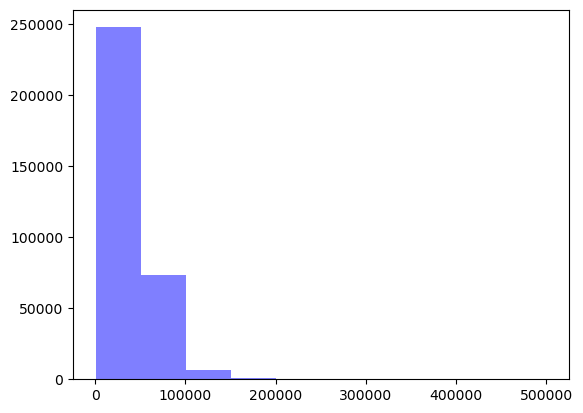

In [27]:
plt.hist(df['보증금'], bins=10, facecolor='blue', alpha=0.5)
plt.show()
# 1억이하, 5000만원 주위로 많이 분포되어 있음을 알 수 있음

In [28]:
# 단지명 기준 매매 많은 상위 40권 아파트 : 이름이 겹치는 곳이 많음 
df['단지명'].value_counts()[:40]

현대            2735
신동아           2541
은마            1956
두산            1943
우성            1784
파크리오          1776
미성            1757
삼성래미안         1593
주공아파트 5단지     1561
잠실엘스          1549
삼성            1499
리센츠           1474
벽산            1449
주공2           1339
래미안힐스테이트고덕    1325
한신            1174
올림픽훼밀리타운      1054
주공5           1024
대림            1016
극동            1006
개포주공1단지        994
삼익             979
대림e-편한세상       953
목동신시가지14       927
동아             905
삼환             880
상계주공7(고층)      865
선사현대아파트        842
삼익그린2차         833
쌍용             829
상계주공6(고층)      818
목동신시가지7        805
중계그린1단지        801
우성1            800
롯데캐슬           797
센트라스           784
성원대치2단지아파트     779
도곡렉슬           773
에스케이북한산시티      771
트리지움           754
Name: 단지명, dtype: int64

In [29]:
# 같은 아파트 이름을 갖는 수를 저장하는 apt_count 열 생성
df['apt_counts'] = 0
df.groupby('단지명')['apt_counts'].count()
df = pd.merge(df, df.groupby('단지명')['apt_counts'].count(), on='단지명', how='left').drop('apt_counts_x', axis=1).rename(columns={'apt_counts_y':'apt_counts'})
df.head(3)

,시군구,동,단지명,전월세구분,전용면적,계약년월,층,건축년도,금리,부동산소비심리,보증금,apt_counts
0,서울특별시 강남구 개포동,개포동,개포6차우성아파트1동~8동,전세,79.97,201601,2,1987,1.5,117.6,44000,120
1,서울특별시 강남구 개포동,개포동,개포6차우성아파트1동~8동,전세,79.97,201601,1,1987,1.5,117.6,42000,120
2,서울특별시 강남구 개포동,개포동,개포우성3차,전세,133.46,201601,6,1984,1.5,117.6,80000,122


In [30]:
# 비슷한 아파트들(숫자같은 것으로)끼리 여러번 나오는 것 방지, top시공사 10곳, 데이터에서 많이 나오는 아파트 25개의 이름 통일하기
# top시공사 10곳은 2022년도 종합건설사업자 시공능력평가액 <토목건축공사업> 참고& 시공사들끼리 동일 아파트를 짓는 경우가 있어 시공사 및 아파트명으로 검색 진행
'''
삼성물산 주식회사 - 래미안
현대건설(주) - 힐스테이트
디엘이앤씨(주) - 이편한|e편한|e-편한
(주)포스코건설 - 더샵
지에스건설(주) - 자이
(주)대우건설 - 푸르지오
현대엔지니어링(주) - 아이파크|IPARK
롯데건설(주) - 롯데캐슬
에스케이에코플랜트(주) - sk|SK|에스케이
에이치디씨현대산업개발(주)
(주)태영건설 - 데시앙
'''
df['top10'] = 0
top10 = ['자이', '푸르지오', '더샵', '롯데캐슬', '이편한|e편한|e-편한', '힐스테이트', '아이파크', '래미안', 'sk|SK|에스케이', '데시앙']

df['단지명'] = df['단지명'].fillna('others')

# top 10 시공사면 1, 아니면 0
for i, brand in enumerate(top10):
    df.loc[df['단지명'].str.contains(brand), 'top10'] = 1

df.head(5)

,시군구,동,단지명,전월세구분,전용면적,계약년월,층,건축년도,금리,부동산소비심리,보증금,apt_counts,top10
0,서울특별시 강남구 개포동,개포동,개포6차우성아파트1동~8동,전세,79.97,201601,2,1987,1.5,117.6,44000,120,0
1,서울특별시 강남구 개포동,개포동,개포6차우성아파트1동~8동,전세,79.97,201601,1,1987,1.5,117.6,42000,120,0
2,서울특별시 강남구 개포동,개포동,개포우성3차,전세,133.46,201601,6,1984,1.5,117.6,80000,122,0
3,서울특별시 강남구 개포동,개포동,개포우성3차,전세,104.43,201601,4,1984,1.5,117.6,52000,122,0
4,서울특별시 강남구 개포동,개포동,개포우성3차,전세,104.43,201601,1,1984,1.5,117.6,55000,122,0


In [31]:
# 데이터에 많이 있는 아파트 대표 25개 리스트
apt_names = ['현대','신동아','은마','두산','우성','파크리오','미성','주공아파트 5단지','잠실엘스','삼성','리센츠','벽산','주공2','한신','올림필훼밀리타운','주공5','대림','개포주공1단지','삼익','목동신시가지14']
# top 10 시공사 키워드와 25개 리스트를 통합
apt_names_list = top10 + apt_names

In [32]:
# `apt_names_list`의 키워드에 해당하는 아파트명이 있는지 여부를 나타내는 새로운 컬럼 생성
df['transformed'] = False

In [33]:
# `apt_names_list`의 키워드에 아파트명이 포함되면 해당 키워드로 아파트명 통일
#  transformed` 컬럼값 True로 변경
for a in (apt_names_list):
    df.loc[df['단지명'].str.contains(a), '단지명'] = a
    df.loc[df['단지명'].str.contains(a), 'transformed'] = True

In [34]:
# 아파트 이름이 변경되지 않았을 경우(`transformed=False` 일 경우) 아파트명을 'others'로 변경
for a in (apt_names):
    df.loc[~df['transformed'], '단지명'] = 'others'

In [35]:
df['단지명'].value_counts()

others          181236
현대               23270
래미안              17304
우성                9828
힐스테이트             9359
푸르지오              7548
한신                6863
삼성                6027
자이                5906
이편한|e편한|e-편한      5808
두산                5643
신동아               5225
롯데캐슬              4643
아이파크              4548
대림                4391
삼익                4304
벽산                4255
미성                2684
sk|SK|에스케이        2383
주공2               2234
은마                1956
데시앙               1813
파크리오              1776
주공5               1603
더샵                1583
주공아파트 5단지         1561
잠실엘스              1549
리센츠               1474
개포주공1단지            994
목동신시가지14           927
Name: 단지명, dtype: int64

In [36]:
# 아파트별 가격 평균 내림차순으로 정렬
apt_price = df.groupby('단지명')['보증금'].agg('mean').sort_values(ascending=False)
print('변환전\n', apt_price[:5])

변환전
 단지명
잠실엘스    80052.517753
파크리오    74547.083333
리센츠     72503.120760
더샵      67250.667720
자이      66949.813749
Name: 보증금, dtype: float64


In [37]:
#가격별로 0~ 인코딩 해주기
for i, a in enumerate(list(apt_price.index)):
    df.loc[df['단지명'] == a, '단지명'] = i 
apt_price = df.groupby('단지명')['보증금'].agg('mean').sort_values(ascending=False)
print('변환후\n', apt_price[:5])

변환후
 단지명
0    80052.517753
1    74547.083333
2    72503.120760
3    67250.667720
4    66949.813749
Name: 보증금, dtype: float64


In [38]:
# 완공연도에서 최소연도 빼서 완공연도 라벨인코딩
print('변환전\n', df['건축년도'].unique()[:5])
df['건축년도'] = df['건축년도'] - df['건축년도'].min()
print('변환후\n', df['건축년도'].unique()[:5])

변환전
 [1987 1984 1982 1983 1993]
변환후
 [26 23 21 22 32]


In [39]:
# 연월 증가하는 순으로 라벨 인코딩 : 계약년월
le = LabelEncoder()
df['계약년월'] = le.fit_transform(df['계약년월'])
print('train 변환후\n', df['계약년월'])
print('test 변환후\n', df['계약년월'].unique()[:5])

train 변환후
 0          0
1          0
2          0
3          0
4          0
          ..
328690    35
328691    35
328692    35
328693    35
328694    35
Name: 계약년월, Length: 328695, dtype: int64
test 변환후
 [0 1 2 3 4]


In [40]:
# 중간 확인
df.head()

,시군구,동,단지명,전월세구분,전용면적,계약년월,층,건축년도,금리,부동산소비심리,보증금,apt_counts,top10,transformed
0,서울특별시 강남구 개포동,개포동,14,전세,79.97,0,2,26,1.5,117.6,44000,120,0,True
1,서울특별시 강남구 개포동,개포동,14,전세,79.97,0,1,26,1.5,117.6,42000,120,0,True
2,서울특별시 강남구 개포동,개포동,14,전세,133.46,0,6,23,1.5,117.6,80000,122,0,True
3,서울특별시 강남구 개포동,개포동,14,전세,104.43,0,4,23,1.5,117.6,52000,122,0,True
4,서울특별시 강남구 개포동,개포동,14,전세,104.43,0,1,23,1.5,117.6,55000,122,0,True


In [41]:
# 동 인코딩하기

#동 EDA
dong_price = df.groupby('동')['보증금'].agg('mean').sort_values(ascending=False)
dong_price[:20]

#현재 데이터에서는 가장 비싼 동은 용산동5가

동
용산동5가     106864.754098
회현동2가     103944.444444
장충동1가     100000.000000
하중동        88505.000000
남대문로5가     84700.000000
청암동        84606.060606
홍파동        84235.294118
도곡동        83019.144189
반포동        82092.443779
성북동1가      82000.000000
내수동        79483.333333
평동         79288.888889
견지동        79250.000000
대치동        76268.968778
회현동1가      74771.698113
사직동        74414.655172
삼성동        72739.922789
압구정동       71916.344866
청담동        69361.712951
역삼동        68991.187912
Name: 보증금, dtype: float64

In [42]:
# 동별 인코딩
for i, d in enumerate(list(dong_price.index)):
    df.loc[df['동'] == d, '동'] = i

df

,시군구,동,단지명,전월세구분,전용면적,계약년월,층,건축년도,금리,부동산소비심리,보증금,apt_counts,top10,transformed
0,서울특별시 강남구 개포동,163,14,전세,79.97,0,2,26,1.50,117.6,44000,120,0,True
1,서울특별시 강남구 개포동,163,14,전세,79.97,0,1,26,1.50,117.6,42000,120,0,True
2,서울특별시 강남구 개포동,163,14,전세,133.46,0,6,23,1.50,117.6,80000,122,0,True
3,서울특별시 강남구 개포동,163,14,전세,104.43,0,4,23,1.50,117.6,52000,122,0,True
4,서울특별시 강남구 개포동,163,14,전세,104.43,0,1,23,1.50,117.6,55000,122,0,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
328690,서울특별시 중랑구 중화동,241,18,전세,59.76,35,13,36,1.75,93.9,28500,282,0,True
328691,서울특별시 중랑구 중화동,241,18,전세,84.03,35,4,36,1.75,93.9,34000,282,0,True
328692,서울특별시 중랑구 중화동,241,18,전세,50.37,35,20,36,1.75,93.9,27000,282,0,True
328693,서울특별시 중랑구 중화동,241,18,전세,59.76,35,13,36,1.75,93.9,29000,282,0,True


In [43]:
# 층 수 확인 
# 최소값이 -2이므로 2를 더해서 음수를 없애고 순서형 범주 처리
# -2, -1, 1, 2와 같은 숫자와 함께 "층"이라는 레이블이 있음
# 머신러닝 모델이 층수를 이해하기 위해서는 층수를 숫자만으로 변환하는 것뿐만 아니라 레이블의 변환도 필요
print('변환전\n', df['층'].values[:5])
df['층'] = df['층'].map(lambda x: x+2)
print('변환후\n', df['층'].values[:5])

변환전
 [2 1 6 4 1]
변환후
 [4 3 8 6 3]


In [44]:
# 시군구,전세,apt_counts,transformed 컬럼 삭제
df = df.drop(['시군구', '전월세구분','apt_counts','transformed'], axis=1)
df.head()

,동,단지명,전용면적,계약년월,층,건축년도,금리,부동산소비심리,보증금,top10
0,163,14,79.97,0,4,26,1.5,117.6,44000,0
1,163,14,79.97,0,3,26,1.5,117.6,42000,0
2,163,14,133.46,0,8,23,1.5,117.6,80000,0
3,163,14,104.43,0,6,23,1.5,117.6,52000,0
4,163,14,104.43,0,3,23,1.5,117.6,55000,0


In [45]:
df.shape

(328695, 10)

# 변수 간 연관분석 - 주성분분석

In [46]:
# 변수로 뽑은 동, 단지명, 전용면적, 계약년월, 층, 건축년도, 보증금 등을 모두 숫자화 함
# 상관분석을 위해 df에서 시군구를 제외하고 동~ 다시 reframe진행함, 표를 보기 위해 영어로 변수 변경
# 상관분석 데이터는 기존 데이터 복사본으로 진행 & 동, 단지명, 전용면적, 계약년월, 층, 건축년도, 추가한 top10, 보증금만 확인

In [47]:
# PCA를 수행 데이터
df_copy = df.copy()
df_copy = df_copy[['동', '단지명', '전용면적', '계약년월', '층', '건축년도','top10', '부동산소비심리','금리','보증금']]
df_copy.columns = ['dong', 'apt_name', 'area', 'contract_month', 'floor', 'construction_year','top10', 'psychology','interest','deposit']

# PCA를 수행합니다.
pca = PCA()
pca.fit(df_copy)

# PCA 결과를 해석
print(pca.explained_variance_ratio_)

[9.99989373e-01 9.22438471e-06 7.77067779e-07 2.32269355e-07
 1.92217724e-07 1.00441415e-07 5.84197270e-08 4.22388673e-08
 1.05608524e-10 2.57678576e-11]


In [48]:
# 첫 번째 주성분이 데이터의 99.99%의 분산을 설명하기 때문에 따로 차원축소를 할 필요가 없음

In [49]:
df_copy.head()

,dong,apt_name,area,contract_month,floor,construction_year,top10,psychology,interest,deposit
0,163,14,79.97,0,4,26,0,117.6,1.5,44000
1,163,14,79.97,0,3,26,0,117.6,1.5,42000
2,163,14,133.46,0,8,23,0,117.6,1.5,80000
3,163,14,104.43,0,6,23,0,117.6,1.5,52000
4,163,14,104.43,0,3,23,0,117.6,1.5,55000


# 상관분석

In [50]:
# 범주화된 항목 카테고리화하면 다른 값들은 괜찮은데 top10은 1 아니면 0값이라 해석에 문제가 생길 수 있음 -> 유지or 삭제

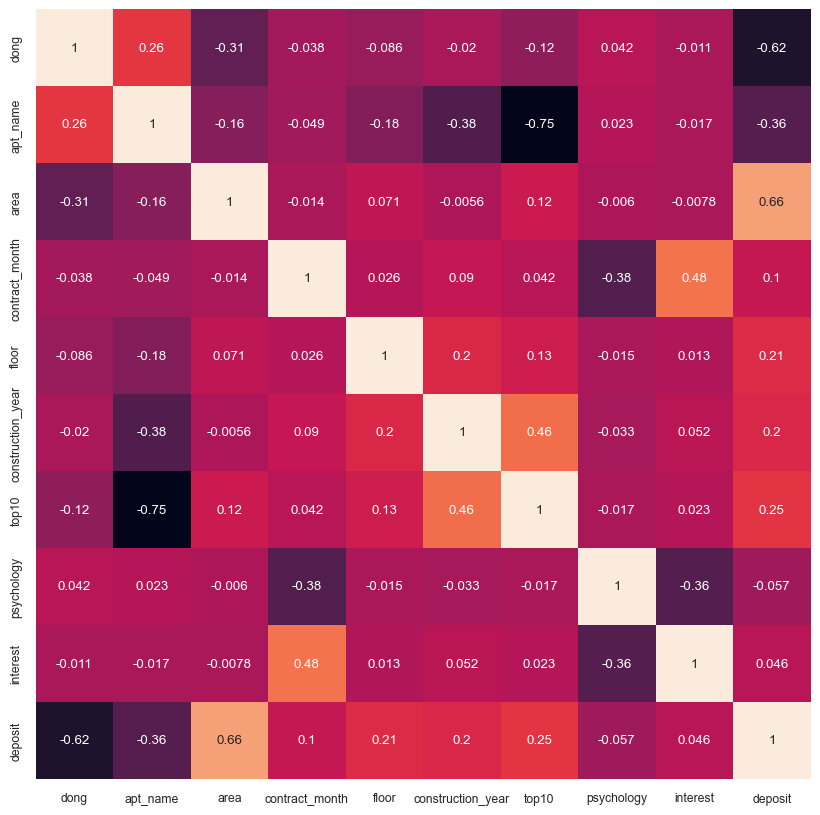

In [51]:
# 상관분석1: 상관 관계 행렬
# 'dong', 'apt_name' 가 범주형 값이기 때문에 더미코드 활용 : 이걸로 돌리면 무지하게 오래 걸립니다.
# df_dummies = pd.get_dummies(df_copy, columns=['dong', 'apt_name'])
# df_corr = df_dummies.corr()

#범주화된 항목 카테고리화 하기
df_copy['top10'] = df_copy['top10'].astype('category').cat.codes
df_copy['dong'] = df_copy['dong'].astype('category').cat.codes
df_copy['apt_name'] = df_copy['apt_name'].astype('category').cat.codes

df_corr=df_copy.corr()

#히트맵
plt.figure(figsize=(10,10))
sns.set(font_scale=0.8)
sns.heatmap(df_corr, annot=True, cbar=False)
plt.show()

In [52]:
# 보증금과 상관관계가 높은 순으로 출력하기
corr_order = df_copy.corr()['deposit'].abs().sort_values(ascending=False)
corr_order

deposit              1.000000
area                 0.662323
dong                 0.615854
apt_name             0.361974
top10                0.253815
floor                0.213032
construction_year    0.197798
contract_month       0.101444
psychology           0.056533
interest             0.046463
Name: deposit, dtype: float64

In [53]:
# 상관분석2 :  선형회귀로 확인하기
# 시각화로 상관분석할 피처 정하기
plot_cols = ['deposit', 'area','top10','floor','construction_year','contract_month','psychology','interest']
plot_df = df_copy.loc[:, plot_cols]

plot_df.head()

,deposit,area,top10,floor,construction_year,contract_month,psychology,interest
0,44000,79.97,0,4,26,0,117.6,1.5
1,42000,79.97,0,3,26,0,117.6,1.5
2,80000,133.46,0,8,23,0,117.6,1.5
3,52000,104.43,0,6,23,0,117.6,1.5
4,55000,104.43,0,3,23,0,117.6,1.5


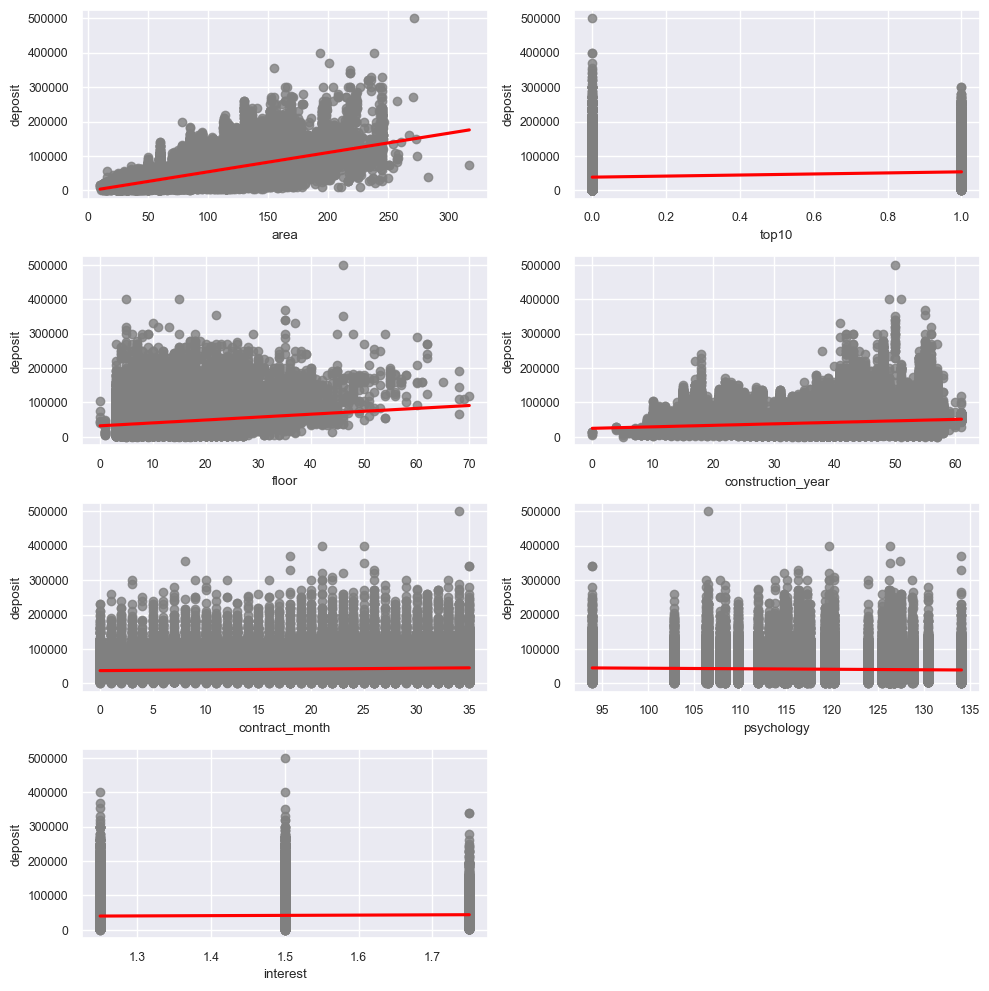

In [54]:
# regplot으로 선형회귀선 표시하기
plt.figure(figsize=(10, 10))
for idx, col in enumerate(plot_cols[1:]):
    ax1 = plt.subplot(4, 2, idx + 1)
    sns.regplot(x=col, y=plot_cols[0], data=plot_df, ax=ax1, color='gray', line_kws={'color': 'red'})
plt.tight_layout()
plt.show()

# 이상치 데이터들이 눈에 보임. 삭제하고 갈건지 아니면 킵고잉할건지?
# 데이터 삭제할거면 기준을 어떻게 할건지?

In [55]:
# 보증금과 비교했을 시
# 면적은 양의 상관관계가 있음
# 층, 건축년도, 계약년도 : 미약한 양의 상관관계가 보임
# top10은 plot으로 시각화 했을시 연관성잘 보이지 않지만, heatmap과 상관관계가 높은 순으로 출력하면 면적 다음으로 영향을 주는 것으로 나옴
# 마찬가지로 미약하나마 부동산소비심리와 금리도 양의 관계를 보여주는 것을 알 수 있음

In [56]:
# 상관분석3 : 스피어만 상관계수로 확인해보기

In [57]:
df_copy = df.copy()
df_copy = df_copy[['동', '단지명', '전용면적', '계약년월', '층', '건축년도','top10', '부동산소비심리','금리','보증금']]
df_copy.columns = ['dong', 'apt_name', 'area', 'contract_month', 'floor', 'construction_year','top10', 'psychology','interest','deposit']
df_copy.head()

,dong,apt_name,area,contract_month,floor,construction_year,top10,psychology,interest,deposit
0,163,14,79.97,0,4,26,0,117.6,1.5,44000
1,163,14,79.97,0,3,26,0,117.6,1.5,42000
2,163,14,133.46,0,8,23,0,117.6,1.5,80000
3,163,14,104.43,0,6,23,0,117.6,1.5,52000
4,163,14,104.43,0,3,23,0,117.6,1.5,55000


In [58]:
# 범주형 변수 순위 변수로 변환
# 범주형의 숫자 값은 연속형의 의미를 가지는 숫자가 아니기 때문에 해석에 있어 주의할 것!
df_copy['top10'] = df_copy['top10'].astype('category').cat.codes
df_copy['dong'] = df_copy['dong'].astype('category').cat.codes
df_copy['apt_name'] = df_copy['apt_name'].astype('category').cat.codes

# 스피어만 상관계수 계산
r = df_copy.corr(method='spearman')

# 스피어만 상관계수를 출력
print(r)

# 스피어만 상관계수 읽는 방법
# 1에 가까울수록 두 변수 간의 상관관계가 강하고, -1에 가까울수록 두 변수 간의 상관관계가 약함 (설사약과 변비약)
# 스피어만 상관계수 값이 0에 가까울수록 두 변수 간의 상관관계가 없음

                       dong  apt_name      area  contract_month     floor  \
dong               1.000000  0.250724 -0.306418       -0.037425 -0.052301   
apt_name           0.250724  1.000000 -0.203587       -0.042304 -0.130582   
area              -0.306418 -0.203587  1.000000       -0.001751  0.054673   
contract_month    -0.037425 -0.042304 -0.001751        1.000000  0.023603   
floor             -0.052301 -0.130582  0.054673        0.023603  1.000000   
construction_year -0.043218 -0.309554  0.112309        0.086569  0.164675   
top10             -0.117449 -0.659481  0.169557        0.041467  0.112995   
psychology         0.035629  0.019390 -0.009397       -0.376385 -0.011016   
interest          -0.006877 -0.012505 -0.000266        0.480647  0.010961   
deposit           -0.669904 -0.365723  0.686982        0.105845  0.151952   

                   construction_year     top10  psychology  interest   deposit  
dong                       -0.043218 -0.117449    0.035629 -0.006877 -0

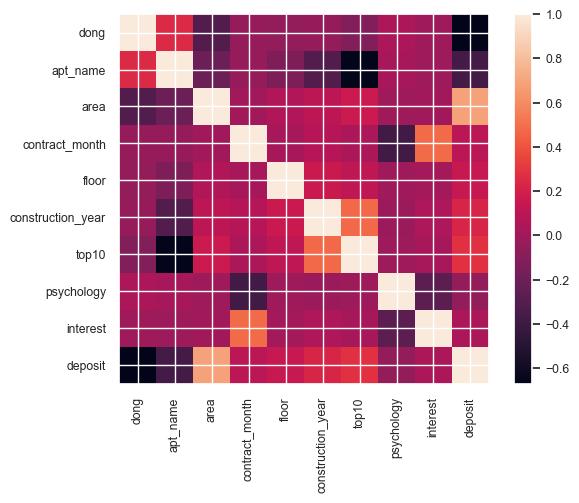

In [59]:
# 히트맵으로 확인
plt.imshow(r)
plt.xticks(np.arange(len(r.columns)), r.columns, rotation='vertical')
plt.yticks(np.arange(len(r.columns)), r.columns)
plt.colorbar()
plt.show()

C:\Users\tjoeun\AppData\Local\Temp\ipykernel_9652\2902047808.py:7: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  plt.tight_layout()


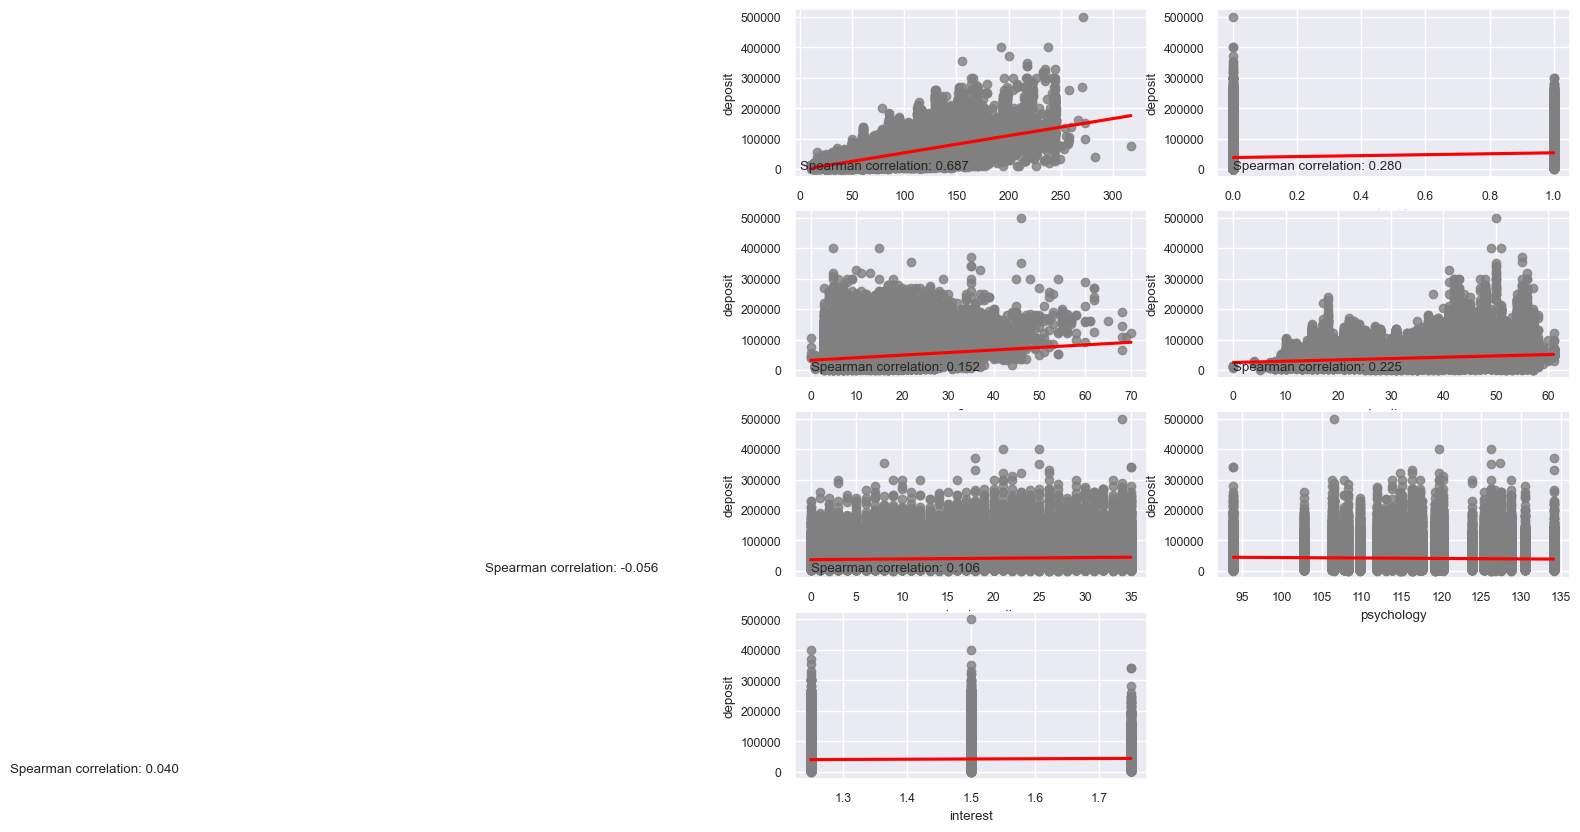

In [60]:
# 산점도로 확인하기
plt.figure(figsize=(10, 10))
for idx, col in enumerate(plot_cols[1:]):
  ax1 = plt.subplot(4, 2, idx + 1)
  sns.regplot(x=col, y=plot_cols[0], data=plot_df, ax=ax1, color='gray', line_kws={'color': 'red'})
  ax1.text(x=0, y=1, s='Spearman correlation: {0:.3f}'.format(plot_df[col].corr(plot_df['deposit'], method='spearman')))
plt.tight_layout()
plt.show()

In [61]:
# 현재 결론으로는 변수로 뽑은 모든 변수들이 다 보증금에 영향을 준다고 나옴. 

# 학습데이터로 다 쓸것인지 아닌지 확인, 확인후 처리된 데이터(df)로 모델링 진행 예정